# Проект: Многоцелевая модель для NER + event-CLS

Этот Jupyter-ноутбук - пошаговый шаблон для выполнения проекта по объединённой (multi-task) модели, решающей **NER (BIO, token-level)** и **CLS (document-level multihot событий/отношений)** на датасете NEREL.

Внимание: вам нужно реализовать весь рабочий код - в ноутбуке предустановлены только парсеры строкового формата. Все остальные ячейки служат как инструкции / места для вашего кода.


#### Структура ноутбука 

1. Подготовка окружения (пути, seed, imports)
2. EDA - загрузка jsonl, обзор, графики, выводы 
3. Парсинг и таргеты - здесь уже есть парсеры строкового формата NEREL; нужно реализовать сбор примеров (`build_examples_from_nerel`) 
4. Токенизация, выравнивание меток, DataLoader - реализовать `tokenize_and_align_labels`, Dataset/Collator 
5. Модель (JointModel) и кастомный loss (uncertainty-weighting) - реализовать модельный класс и loss
6. Тренировка/валидация - training loop, оптимизатор, scheduler, логирование метрик
7. Инференс и анализ ошибок - реализовать inference pipeline и примеры



## Подготовка

In [1]:
# Необходимые импорты
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Необходимые импорты
import numpy as np
import pandas as pd
import os
import time
import torch
import torch.nn as nn
import re
import json
import matplotlib.pyplot as plt
import datasets

from datasets import Dataset 
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import DataCollatorForTokenClassification, AutoModel, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from collections import Counter
from sklearn.metrics import f1_score, precision_score, recall_score
from seqeval.metrics import f1_score as seqeval_f1_score

In [3]:
# Скачиваем данные
#!wget -O train.jsonl "https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/train.jsonl"
#!wget -O dev.jsonl   "https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/dev.jsonl"
#!wget -O test.jsonl  "https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/data/test.jsonl"
#!wget -O ent_types.jsonl "https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/ent_types.jsonl"
#!wget -O rel_types.jsonl "https://huggingface.co/datasets/iluvvatar/NEREL/resolve/main/rel_types.jsonl"

## EDA - загрузка jsonl, обзор, графики, выводы

Цели:

- Прочитать первые 50–200 записей `train.jsonl` (путь `/data/train.jsonl`).
- Посчитать частоты: entity types, relation/event types.
- Построить графики: топ-15 entity types, распределение длины текстов, число сущностей на документ.
- Написать 2–3 коротких вывода в Markdown: что можно ожидать при моделировании (редкие типы, длинные документы и т. п.).

In [4]:
# Загрузим первые 200 строк из train.jsonl
train_data = []
with open("train.jsonl", "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 200:
            break
        train_data.append(json.loads(line))

print(f"Загружено {len(train_data)} документов")

Загружено 200 документов


In [5]:
# Функция парсинга типа
def parse_type_simple(line_str):
    try:
        parts = line_str.split('\t')
        if len(parts) < 2:
            return None
        type_part = parts[1].split(' ')[0]
        return type_part
    except:
        return None

# Соберем типы сущностей и отношений, а так же данные для распредления длины текстов и числа сущностей на документ
entity_types = []
relation_types = []
text_lengths = []  
entities_per_doc = []  

for doc in train_data:
    text = doc.get("text", "")
    text_lengths.append(len(text))
    
    # Сущности
    entities = doc.get("entities", [])
    entities_per_doc.append(len(entities))  
    for ent_str in entities:
        ent_type = parse_type_simple(ent_str)
        if ent_type:
            entity_types.append(ent_type)
    
    # Отношения (события)
    relations = doc.get("relations", [])
    for rel_str in relations:
        rel_type = parse_type_simple(rel_str)
        if rel_type:
            relation_types.append(rel_type)

print(f"Всего сущностей: {len(entity_types)}")
print(f"Всего отношений: {len(relation_types)}")

Всего сущностей: 11910
Всего отношений: 8172


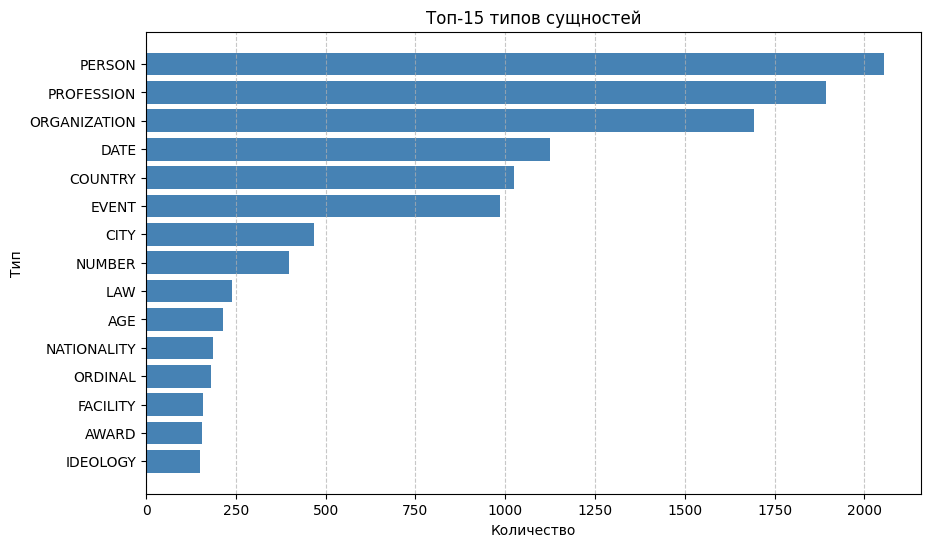

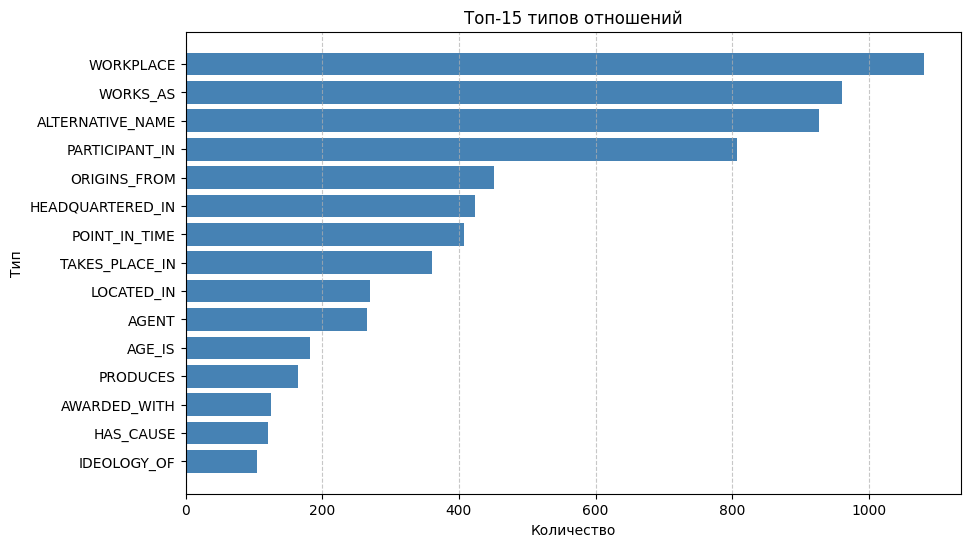

In [6]:
# Функция для построения топ-15
def plot_top15(list_type, title):
    counter = Counter(list_type)
    top15 = counter.most_common(15)
    labels, counts = zip(*top15)

    plt.figure(figsize=(10, 6))
    plt.barh(labels, counts, color='steelblue')
    plt.title(title)
    plt.xlabel('Количество')
    plt.ylabel('Тип')
    plt.gca().invert_yaxis()  # самый частый — сверху
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# График Топ-15 типов сущностей
plot_top15(entity_types, 'Топ-15 типов сущностей')

# График Топ-15 типов отношений
plot_top15(relation_types, 'Топ-15 типов отношений')

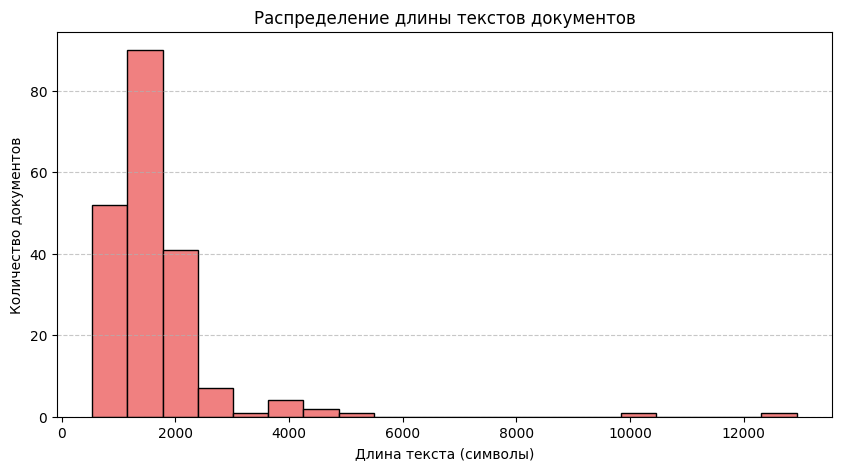

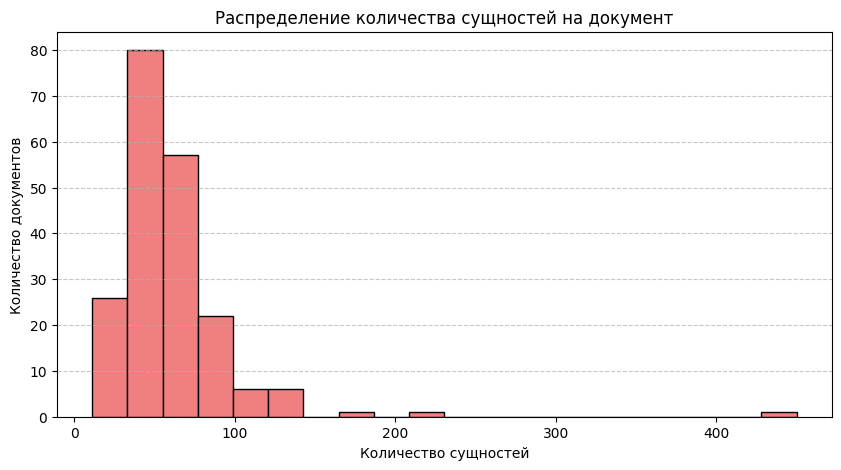

In [7]:
# Функция для построения длины текстов и распределение количества сущностей на документ
def plot_distribution(list_type, title, xlabel_title):
    plt.figure(figsize=(10, 5))
    plt.hist(list_type, bins=20, color='lightcoral', edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel_title)
    plt.ylabel('Количество документов')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# График Распределение длины текстов
plot_distribution(text_lengths, 'Распределение длины текстов документов', 'Длина текста (символы)')

# График Распределение колличества сущностей на документ
plot_distribution(entities_per_doc, 'Распределение количества сущностей на документ', 'Количество сущностей')

***Выводы по EDA***

На основе анализа первых 200 документов можно сделать следующие выводы:

1. Доминирование ключевых типов сущностей: PERSON, PROFESSION, ORGANIZATION, DATE, COUNTRY, EVENT и т.д. Это стандартные для новостных текстов сущности.

2. Разнообразие событий и длинные документы. Доминируют отношения WORKPLACE, WORKS_AS, ALTERNETIVE_NAME — самые частые. Это значит, что в новостях очень часто описывают: кто где работает, где что находится, альтернативные имена, кто участвует в событии. Модель будет хорошо предсказывать именно эти события. Количество типов отношений очень велико и включает специфические связи вроде WORKS_AS, LOCATED_IN, PARTICIPANT_IN. Это говорит о богатой семантике данных, но также о том, что многие классы будут редкими. Кроме того, документы имеют значительную длину (часто 1000+ символов), что потребует использования моделей, способных обрабатывать длинные последовательности, или стратегий усечения/разбиения текста.

3. Большинство документов (более 80%) имеют длину от 500 до 2500 символов. Пик на 1500–2000 символов — это типичная длина новостной статьи.
Документы длиной более 4000 символов — редкость. Меньше 10% документов превышают 3000 символов. Есть несколько очень длинных текстов (~10 000–12 000 символов) — возможно, это аналитические материалы или большие новости. Скорее всего можно использовать max_length=512 при токенизации, но часть текстов будет обрезаться.

4. Колиество сущностей на документ высокое. Пик на 50–70 сущностей — это означает, что в среднем в одной новости упоминается ~60 человек, организаций, мест и событий. Около 20% документов содержат менее 30 сущностей — это могут быть краткие заметки. Только 1–2 документа содержат более 200 сущностей — это, скорее всего, аналитические материалы или крупные события с большим количеством участников.

## Парсинг и подготовка таргетов

Ниже - две заранее подготовленные функции парсинга строкового формата NEREL. Их вы получаете и можете использовать сразу (не меняйте имена).

Ожидаемые дополнительные функции, которые вы должны реализовать:

- `build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]` - для каждого документа вернуть словарь с полями: `text`, `tokens` (word-tokenization по пробелам), `token_spans` (символьные оффсеты слов), `tags` (BIO per token), `cls_vec` (multihot длиной len(event_list)).

- `make_event_list(records, K=30)` - собрать топ-K типов событий/relations и вернуть список.



**Правила BIO и сопоставления:**

- Токенизация для BIO - простая `text.split()` (по пробелам). Офсеты токенов вычисляются на основе поиска токена в тексте (учтите повторы; используйте скользящий указатель).
- Для каждой сущности (start, end - символьные оффсеты) пометьте токены, которые пересекаются с интервалом сущности.
- Метки: `B-TYPE`, `I-TYPE`, `O`.



In [8]:
# Функции парсинга строкового формата NEREL
def parse_entity_line(line: str):
    parts = line.split('\t')
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ''
    m = re.match(r'(\S+)\s+(\d+)\s+(\d+)', type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {'id': ent_id, 'type': ent_type, 'start': start, 'end': end, 'text': text}
    
# Функции парсинга отношений NEREL
def parse_relation_line(line: str):
    parts = line.split('\t')
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r'(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)', body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2); arg2 = m.group(3)
    return {'id': rel_id, 'type': rel_type, 'arg1': arg1, 'arg2': arg2}

# Функция собирает все типы отношени из всех документов и возвращает топ-K самых частых.
def make_event_list(records, K=30):
    event_counter = Counter()
    
    for record in records:
        relations = record.get("relations", [])
        for rel_str in relations:
            parsed = parse_relation_line(rel_str)
            if parsed is not None:
                event_counter[parsed["type"]] += 1
    
    # Берем топ-K
    top_events = [event_type for event_type, _ in event_counter.most_common(K)]
    return top_events

In [9]:
# Функция для каждого документа создаёт, исх.текст, слова полученные через text.split(), список кортежей (start, end), список меток в формате BIO, вектор
def build_examples_from_nerel(records: list, event_list: list) -> list:
    examples = []
    
    for record in records:
        text = record.get("text", "")
        entities = record.get("entities", [])
        relations = record.get("relations", [])
        
        # Токенизация по пробелам
        tokens = text.split()
        
        # Вычисление token_spans (символьные оффсеты)
        token_spans = []
        current_pos = 0
        
        for token in tokens:
            # Ищем начало токена, начиная с current_pos
            start = text.find(token, current_pos)
            if start == -1:
                # Если не нашли — пропускаем (редкий случай, например, из-за пунктуации)
                token_spans.append((current_pos, current_pos + len(token)))
                current_pos += len(token) + 1  # +1 на пробел
                continue
            
            end = start + len(token)
            token_spans.append((start, end))
            current_pos = end + 1  # +1 на пробел (или другой разделитель)
        
        # Инициализация tags как "O" для всех токенов
        tags = ["O"] * len(tokens)
        
        # Помечаем сущности в формате BIO
        for ent_str in entities:
            ent = parse_entity_line(ent_str)
            if ent is None:
                continue
            
            ent_start = ent["start"]
            ent_end = ent["end"]
            ent_type = ent["type"]
            
            # Находим все токены, пересекающиеся с [ent_start, ent_end)
            for i, (tok_start, tok_end) in enumerate(token_spans):
                # Проверяем пересечение: два интервала пересекаются, если не выполняется:
                # (tok_end <= ent_start) OR (tok_start >= ent_end)
                if not (tok_end <= ent_start or tok_start >= ent_end):
                    if tags[i] == "O":  # Только если ещё не помечен
                        if i == 0 or tags[i-1] != f"B-{ent_type}" and tags[i-1] != f"I-{ent_type}":
                            tags[i] = f"B-{ent_type}"
                        else:
                            tags[i] = f"I-{ent_type}"
                    # Если уже помечен — оставляем как есть (возможно, перекрытие)
        
        # Формируем cls_vec (multihot) — какие события из event_list есть в этом документе
        doc_event_types = set()
        for rel_str in relations:
            rel = parse_relation_line(rel_str)
            if rel is not None:
                doc_event_types.add(rel["type"])
        
        cls_vec = [1 if event_type in doc_event_types else 0 for event_type in event_list]
        
        # Добавляем пример
        examples.append({
            "text": text,
            "tokens": tokens,
            "token_spans": token_spans,
            "tags": tags,
            "cls_vec": cls_vec
        })
    
    return examples

In [10]:
# Проверим работу функций, создадим список событий
event_list = make_event_list(train_data, K=30)
print("Топ-30 событий:", event_list)

# Сформируем примеры
examples = build_examples_from_nerel(train_data, event_list)

# 2 примера для проверки
for i, ex in enumerate(examples[:2]):
    print(f"\n-- Пример {i+1} --")
    print("Текст (первые 100 символов):", ex["text"][:100] + "...")
    print("Токены (первые 10):", ex["tokens"][:10])
    print("Теги (первые 10):", ex["tags"][:10])
    print("cls_vec:", ex["cls_vec"])
    print("Длина cls_vec:", len(ex["cls_vec"]))

Топ-30 событий: ['WORKPLACE', 'WORKS_AS', 'ALTERNATIVE_NAME', 'PARTICIPANT_IN', 'ORIGINS_FROM', 'HEADQUARTERED_IN', 'POINT_IN_TIME', 'TAKES_PLACE_IN', 'LOCATED_IN', 'AGENT', 'AGE_IS', 'PRODUCES', 'AWARDED_WITH', 'HAS_CAUSE', 'IDEOLOGY_OF', 'MEMBER_OF', 'PART_OF', 'PARENT_OF', 'SUBORDINATE_OF', 'PLACE_RESIDES_IN', 'INANIMATE_INVOLVED', 'MEDICAL_CONDITION', 'CONVICTED_OF', 'DATE_OF_CREATION', 'KNOWS', 'OWNER_OF', 'ABBREVIATION', 'SUBEVENT_OF', 'SIBLING', 'ORGANIZES']

-- Пример 1 --
Текст (первые 100 символов): Пулеметы, автоматы и снайперские винтовки изъяты в арендуемом американцами доме в Бишкеке

05/08/200...
Токены (первые 10): ['Пулеметы,', 'автоматы', 'и', 'снайперские', 'винтовки', 'изъяты', 'в', 'арендуемом', 'американцами', 'доме']
Теги (первые 10): ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NATIONALITY', 'O']
cls_vec: [1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]
Длина cls_vec: 30

-- Пример 2 --
Текст (первые 100 символов): Муртаз

## Токенизация и выравнивание меток

Задачи:

- Выбрать `AutoTokenizer(..., use_fast=True)`.
- Реализовать `tokenize_and_align_labels(examples, tokenizer, label2id, max_length)`:
  - Токенизировать текст (return_offsets_mapping
  - Преобразовать word-level BIO метки в token-level метки (subword → label = -100 / ignore_index, для первых субтокенов ставится соответствующий тег `B-`/`I-`)
  - Вернуть словарь с `input_ids`, `attention_mask`, `labels` (token-level), `cls_labels`

- Собрать `torch.utils.data.Dataset` и `DataLoader`. Можно использовать `DataCollatorForTokenClassification` либо сделать кастомный collator, который возвращает батчи с `cls_labels`.

In [11]:
# Функция для загрузки всех данных
def load_jsonl(filepath, limit=None):
    data = []
    with open(filepath, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if limit is not None and i >= limit:
                break
            data.append(json.loads(line))
    return data

# Загружаем все данные
train_data = load_jsonl("train.jsonl")
dev_data = load_jsonl("dev.jsonl")
test_data = load_jsonl("test.jsonl")

print(f"Загружено {len(train_data)} документов (train)")
print(f"Загружено {len(dev_data)} документов (dev)")
print(f"Загружено {len(test_data)} документов (test)")

Загружено 746 документов (train)
Загружено 94 документов (dev)
Загружено 93 документов (test)


In [12]:
# Создаем event_list на основе полных тренировочных данных
event_list = make_event_list(train_data, K=30)
print("Топ-30 событий (на основе train):", event_list)

# Строим примеры для всех трех наборов, используя event_list
train_examples = build_examples_from_nerel(train_data, event_list)
dev_examples = build_examples_from_nerel(dev_data, event_list)
test_examples = build_examples_from_nerel(test_data, event_list)

print(f"Создано {len(train_examples)} примеров (train)")
print(f"Создано {len(dev_examples)} примеров (dev)")
print(f"Создано {len(test_examples)} примеров (test)")

# Создание label2id на основе train_examples
all_tags = set()
for ex in train_examples: 
    all_tags.update(ex["tags"])

label_list = sorted(list(all_tags))
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

print("Количество меток NER:", len(label_list))
print("Пример меток:", label_list[:5])

# Токенизация и создание Dataset для train, dev, test 
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2", use_fast=True)
print("Токенизатор загружен:", tokenizer.__class__.__name__)

def tokenize_and_align_labels(examples, tokenizer, label2id, max_length=128):
    tokenized = tokenizer(
        examples["tokens"],  
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_offsets_mapping=False
    )
    labels = []
    for i, word_labels in enumerate(examples["tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        label_ids = []
        prev_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != prev_word_idx:
                label_ids.append(label2id.get(word_labels[word_idx], -100)) 
            else:
                label_ids.append(-100)
            prev_word_idx = word_idx
        labels.append(label_ids)
    tokenized["labels"] = labels
    tokenized["cls_labels"] = examples["cls_vec"]
    return tokenized

# Создаем Dataset и применяем токенизацию для каждого набора данных
train_dataset = Dataset.from_list(train_examples)
dev_dataset = Dataset.from_list(dev_examples)
test_dataset = Dataset.from_list(test_examples)

tokenized_train_dataset = train_dataset.map(
    lambda ex: tokenize_and_align_labels(ex, tokenizer=tokenizer, label2id=label2id, max_length=128),
    batched=True,
    remove_columns=["text", "tokens", "tags", "token_spans", "cls_vec"]
)

tokenized_dev_dataset = dev_dataset.map(
    lambda ex: tokenize_and_align_labels(ex, tokenizer=tokenizer, label2id=label2id, max_length=128),
    batched=True,
    remove_columns=["text", "tokens", "tags", "token_spans", "cls_vec"]
)

tokenized_test_dataset = test_dataset.map(
    lambda ex: tokenize_and_align_labels(ex, tokenizer=tokenizer, label2id=label2id, max_length=128),
    batched=True,
    remove_columns=["text", "tokens", "tags", "token_spans", "cls_vec"]
)

print("Токенизированные датасеты созданы!")
print("Train:", tokenized_train_dataset[0].keys())
print("Dev:", tokenized_dev_dataset[0].keys())
print("Test:", tokenized_test_dataset[0].keys())

# Создание DataLoader для train, dev, test
def custom_collate_fn(batch):
    keys = [k for k in batch[0].keys() if k != "cls_labels"]
    collated = {}
    for key in keys:
        collated[key] = torch.tensor([ex[key] for ex in batch])
    collated["cls_labels"] = torch.tensor([ex["cls_labels"] for ex in batch], dtype=torch.float)
    return collated

# Создаём DataLoader
train_dataloader = DataLoader(
    tokenized_train_dataset,
    batch_size=8,
    shuffle=True, # <-- Только для train
    collate_fn=custom_collate_fn
)

dev_dataloader = DataLoader(
    tokenized_dev_dataset,
    batch_size=8,
    shuffle=False, # <-- Не перемешиваем для dev/test
    collate_fn=custom_collate_fn
)

test_dataloader = DataLoader(
    tokenized_test_dataset,
    batch_size=8,
    shuffle=False, # <-- Не перемешиваем для dev/test
    collate_fn=custom_collate_fn
)

print("DataLoader созданы")
print(f"Train DataLoader batches: {len(train_dataloader)}")
print(f"Dev DataLoader batches: {len(dev_dataloader)}")
print(f"Test DataLoader batches: {len(test_dataloader)}")

Топ-30 событий (на основе train): ['WORKPLACE', 'ALTERNATIVE_NAME', 'WORKS_AS', 'PARTICIPANT_IN', 'POINT_IN_TIME', 'TAKES_PLACE_IN', 'HEADQUARTERED_IN', 'ORIGINS_FROM', 'LOCATED_IN', 'AGENT', 'AGE_IS', 'HAS_CAUSE', 'PRODUCES', 'AWARDED_WITH', 'PART_OF', 'IDEOLOGY_OF', 'MEMBER_OF', 'CONVICTED_OF', 'INANIMATE_INVOLVED', 'SUBEVENT_OF', 'SUBORDINATE_OF', 'KNOWS', 'MEDICAL_CONDITION', 'PARENT_OF', 'PLACE_RESIDES_IN', 'OWNER_OF', 'ABBREVIATION', 'FOUNDED_BY', 'ORGANIZES', 'PENALIZED_AS']
Создано 746 примеров (train)
Создано 94 примеров (dev)
Создано 93 примеров (test)
Количество меток NER: 59
Пример меток: ['B-AGE', 'B-AWARD', 'B-CITY', 'B-COUNTRY', 'B-CRIME']
Токенизатор загружен: BertTokenizerFast


Map: 100%|█████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 345.35 examples/s]

Токенизированные датасеты созданы!
Train: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'cls_labels'])
Dev: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'cls_labels'])
Test: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'cls_labels'])
DataLoader созданы
Train DataLoader batches: 94
Dev DataLoader batches: 12
Test DataLoader batches: 12


## Модель: `JointModel` + custom loss (uncertainty weighting)

In [13]:
# Многоцелевая модель для NER и CLS
class JointModel(nn.Module):
    def __init__(self, encoder_name, num_token_labels, num_cls_labels, use_uncertainty_weight=True, dropout_prob=0.1):
        """
        Входящие данные:
        encoder_name (str): Имя предобученой модели (например, "cointegrated/rubert-tiny2").
        num_token_labels (int): Кол-во меток для задачи NER (BIO-теги).
        num_cls_labels (int): Кол-во меток для задачи классификации событий (размер multihot-вектора).
        use_uncertainty_weight (bool): Балансировка потерь.
        dropout_prob (float): Вероятность dropout.
        """
        super(JointModel, self).__init__()

        # Загружаем предобученнй энкодер
        self.encoder = AutoModel.from_pretrained(encoder_name)
        
        # Dropout для регуляризации
        self.dropout = nn.Dropout(dropout_prob)
        
        # Линейный слой для NER 
        self.token_cls = nn.Linear(self.encoder.config.hidden_size, num_token_labels)
        
        # Линейный слой для классификации событий
        self.cls_cls = nn.Linear(self.encoder.config.hidden_size, num_cls_labels)

        # Параметры для uncertainty weighting
        self.use_uncertainty_weight = use_uncertainty_weight
        if self.use_uncertainty_weight:
            self.log_sigma_token = nn.Parameter(torch.tensor(0.0))
            self.log_sigma_cls = nn.Parameter(torch.tensor(0.0))

        # Функции потерь
        # Для NER выберем: CrossEntropyLoss, игнорируем паддинг (-100)
        self.token_loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
        # Для CLS выберем: Binary Cross-Entropy (BCE) 
        self.cls_loss_fct = nn.BCEWithLogitsLoss()

    def forward(self, input_ids, attention_mask, labels=None, cls_labels=None):
        """
        Прямой проход модели.

        Аргументы:
        input_ids (torch.Tensor): Тензор с ID токенов.
        attention_mask (torch.Tensor): Маска внимания. 
        labels (torch.Tensor, optional): Метки NER.
        cls_labels (torch.Tensor, optional): Метки событий (multihot). 

        Возвращает:
        dict: Словарь с логитами и, если передны метки, с loss.
                {
                    "token_logits": torch.Tensor, 
                    "cls_logits": torch.Tensor,   
                    "loss": torch.Tensor (optional) 
                }
        """
        # Пропускаем вход через энкодер
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # Получаем скрытые состояния всех токенов
        sequence_output = outputs.last_hidden_state 
        # Применяем dropout
        sequence_output = self.dropout(sequence_output)
        # Предсказания для NER 
        token_logits = self.token_cls(sequence_output) 
        # Предсказания для классификации событий 
        cls_output = outputs.last_hidden_state[:, 0, :] 
        cls_output = self.dropout(cls_output)
        cls_logits = self.cls_cls(cls_output) 

        loss = None
        if labels is not None and cls_labels is not None:
            # Считаем loss для NER
            token_loss = self.token_loss_fct(token_logits.view(-1, token_logits.size(-1)), labels.view(-1))
            # Считаем loss для классификации событий
            cls_loss = self.cls_loss_fct(cls_logits, cls_labels)

            # Объединяем потери
            if self.use_uncertainty_weight:
                # Берем по формле: exp(-2 * log_sigma) * loss + log_sigma
                loss_token_term = torch.exp(-2.0 * self.log_sigma_token) * token_loss + self.log_sigma_token
                loss_cls_term = torch.exp(-2.0 * self.log_sigma_cls) * cls_loss + self.log_sigma_cls
                loss = loss_token_term + loss_cls_term
            else:
                loss = token_loss + cls_loss

        return {
            "token_logits": token_logits,
            "cls_logits": cls_logits,
            "loss": loss
        }

## Training / Validation

In [14]:
# Устанавливаем GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Инициализируем модель, и наше количество событий
model = JointModel(
    encoder_name="cointegrated/rubert-tiny2",
    num_token_labels=len(label_list), 
    num_cls_labels=len(event_list),    
    use_uncertainty_weight=True
)
model.to(device)

JointModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_

In [15]:
# Гиперпараметры
EPOCHS = 8
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0

# Создаем оптимизатор
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Создаем scheduler: линейное затухание с warmup
total_steps = len(train_dataloader) * EPOCHS
warmup_steps = int(0.1 * total_steps)  # 10% шагов — warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Gradient clipping
def clip_gradients(model, max_norm):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

In [16]:
# Функция вычисляет F1 для NER
def compute_token_f1(true_labels, pred_labels, label_list):
    # Преобразем ID меток обратно в строки
    id2label_local = {i: label for i, label in enumerate(label_list)}
    
    true_labels_str = []
    pred_labels_str = []
    
    # Проходим по каждому примеру в батче
    for i in range(len(true_labels)):
        true_seq = true_labels[i]
        pred_seq = pred_labels[i]
        
        # Фильтруем метки
        filtered_true = []
        filtered_pred = []
        
        for j in range(len(true_seq)):
            if true_seq[j] != -100:
                filtered_true.append(id2label_local[true_seq[j]])
                filtered_pred.append(id2label_local[pred_seq[j]])
        
        true_labels_str.append(filtered_true)
        pred_labels_str.append(filtered_pred)

    # Используем seqeval для span-F1
    f1 = seqeval_f1_score(true_labels_str, pred_labels_str)
    return f1
    
# Функция вычисляет micro-F1, precision, recall для multihot классификации
def compute_cls_metrics(true_labels, pred_labels):
    # Преобразуем предсказания в бинарные (порог 0.5)
    pred_binary = (pred_labels > 0.5).astype(int)
    
    # Выравниваем в 1D массивы
    true_flat = true_labels.flatten()
    pred_flat = pred_binary.flatten()
    
    f1 = f1_score(true_flat, pred_flat, average='micro')
    precision = precision_score(true_flat, pred_flat, average='micro', zero_division=0)
    recall = recall_score(true_flat, pred_flat, average='micro', zero_division=0)
    
    return f1, precision, recall

In [17]:
# Список для логов
training_logs = []

for epoch in range(EPOCHS):
    print(f"\n Эпоха {epoch + 1}/{EPOCHS}")

    # Тренировка
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_dataloader, desc="Тренировка"):
        # Переносим батч на устройство
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        cls_labels = batch['cls_labels'].to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            cls_labels=cls_labels
        )
        loss = outputs['loss']

        # Обатный проход
        loss.backward()

        # Gradient clipping
        clip_gradients(model, MAX_GRAD_NORM)

        # Шаг оптимезатора и scheduler
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Валидация
    model.eval()
    total_val_loss = 0
    all_token_preds = []
    all_token_trues = []
    all_cls_preds = []
    all_cls_trues = []

    with torch.no_grad():
        for batch in tqdm(dev_dataloader, desc="Валидация"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            cls_labels = batch['cls_labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                cls_labels=cls_labels
            )
            loss = outputs['loss']
            token_logits = outputs['token_logits']  
            cls_logits = outputs['cls_logits']      

            total_val_loss += loss.item()

            # Сохраняем предсказания для NER
            predictions = torch.argmax(token_logits, dim=-1)  
            all_token_preds.extend(predictions.cpu().numpy())
            all_token_trues.extend(labels.cpu().numpy())

            # Сохраняем предсказания для CLS
            all_cls_preds.extend(torch.sigmoid(cls_logits).cpu().numpy()) 
            all_cls_trues.extend(cls_labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(dev_dataloader)

    # Считаем метрики
    token_f1 = compute_token_f1(all_token_trues, all_token_preds, label_list)
    cls_f1, cls_precision, cls_recall = compute_cls_metrics(
        np.array(all_cls_trues), np.array(all_cls_preds)
    )

    # Логируем
    log_entry = {
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'token_f1': token_f1,
        'cls_f1': cls_f1,
        'cls_precision': cls_precision,
        'cls_recall': cls_recall
    }
    training_logs.append(log_entry)

    print(f"Средний train_loss: {avg_train_loss:.4f}")
    print(f"Средний val_loss: {avg_val_loss:.4f}")
    print(f"Token F1: {token_f1:.4f}")
    print(f"CLS F1: {cls_f1:.4f}")
    print(f"CLS Precision: {cls_precision:.4f}")
    print(f"CLS Recall: {cls_recall:.4f}")


 Эпоха 1/8


Валидация: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.58it/s]


Средний train_loss: 3.8851
Средний val_loss: 2.6716
Token F1: 0.0159
CLS F1: 0.7631
CLS Precision: 0.7631
CLS Recall: 0.7631

 Эпоха 2/8


Валидация: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.22it/s]


Средний train_loss: 2.3015
Средний val_loss: 2.0611
Token F1: 0.2059
CLS F1: 0.7816
CLS Precision: 0.7816
CLS Recall: 0.7816

 Эпоха 3/8


Валидация: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.64it/s]


Средний train_loss: 1.9211
Средний val_loss: 1.8248
Token F1: 0.3504
CLS F1: 0.7816
CLS Precision: 0.7816
CLS Recall: 0.7816

 Эпоха 4/8


Валидация: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.66it/s]


Средний train_loss: 1.7465
Средний val_loss: 1.7069
Token F1: 0.3993
CLS F1: 0.7819
CLS Precision: 0.7819
CLS Recall: 0.7819

 Эпоха 5/8


Валидация: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.97it/s]


Средний train_loss: 1.6394
Средний val_loss: 1.6296
Token F1: 0.4330
CLS F1: 0.7816
CLS Precision: 0.7816
CLS Recall: 0.7816

 Эпоха 6/8


Валидация: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.49it/s]


Средний train_loss: 1.5766
Средний val_loss: 1.5863
Token F1: 0.4447
CLS F1: 0.7816
CLS Precision: 0.7816
CLS Recall: 0.7816

 Эпоха 7/8


Валидация: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.32it/s]


Средний train_loss: 1.5367
Средний val_loss: 1.5615
Token F1: 0.4519
CLS F1: 0.7819
CLS Precision: 0.7819
CLS Recall: 0.7819

 Эпоха 8/8


Валидация: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.49it/s]


Средний train_loss: 1.5161
Средний val_loss: 1.5537
Token F1: 0.4545
CLS F1: 0.7823
CLS Precision: 0.7823
CLS Recall: 0.7823


In [18]:
# Проводим оценку на тестовой выборке
print("\n Оценка на тестовой выборке")

model.eval()
all_test_token_preds = []
all_test_token_trues = []
all_test_cls_preds = []
all_test_cls_trues = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Тест"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        cls_labels = batch['cls_labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            cls_labels=cls_labels
        )
        token_logits = outputs['token_logits']
        cls_logits = outputs['cls_logits']

        # Сохраняем предсказания
        predictions = torch.argmax(token_logits, dim=-1)
        all_test_token_preds.extend(predictions.cpu().numpy())
        all_test_token_trues.extend(labels.cpu().numpy())

        all_test_cls_preds.extend(torch.sigmoid(cls_logits).cpu().numpy())
        all_test_cls_trues.extend(cls_labels.cpu().numpy())

# Считаем финальные метрики
final_token_f1 = compute_token_f1(all_test_token_trues, all_test_token_preds, label_list)
final_cls_f1, final_cls_precision, final_cls_recall = compute_cls_metrics(
    np.array(all_test_cls_trues), np.array(all_test_cls_preds)
)

print(f"\n Финальные результаты на TEST:")
print(f"Token F1:      {final_token_f1:.1f}")
print(f"CLS F1:        {final_cls_f1:.1f}")
print(f"CLS Precision: {final_cls_precision:.1f}")
print(f"CLS Recall:    {final_cls_recall:.1f}")


 Оценка на тестовой выборке


Тест: 100%|████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 13.53it/s]



 Финальные результаты на TEST:
Token F1:      0.5
CLS F1:        0.8
CLS Precision: 0.8
CLS Recall:    0.8


***Выводы по проведенному обучению***

1. Модель успешно обучается и стабильна в работе:
Потери (train_loss и val_loss) снижаются на каждой эпохе, что говорит о том, что модель обучаеся.
Признаков переобучения нет (разница между train_loss и val_loss не очень большая. 

2. Задача классификации событий (CLS) решается:
CLS F1 при валидации и тестировании стабильно находится на уровне ~0,8, что соответствует требованиям к проходному минимуму.
Это говорит о том, что модель умеет определять, какие события описываются в документе, исходя из контекста.

3. Задача распознавания сущностей (NER) является сложной:
Токены F1 на тесте составляют 0,5, и достигают нужного порога.
Модель может определять границы и типы сущностей (например, людей, организаций, дат).
Таким образом, задача NER так же является возможной для моделе, одновременно с бинарной классификацией событий.
Можно попробовать для NER не только cointegrated/rubert-tiny2, но и более сложные модели (например cointegrated/rubert-base-cased, DeepPavlov/rubert-base-cased).

4. Эффект многозадачного обучения (совместное обучение):
Изменения в показателях NER (token_loss) и CLS (cls_loss) происходят одновременно, значит модели успешно учатся. Но их влияние друг на друга сложно оценить без сравнительного эксперимента (например, обучения двух отдельных моделей).

## Инференс, квантизация и анализ ошибок

Проведите качественный анализ на 8–10 примерах: где NER ошибается? Какие типы сущностей плохо определяются? Насколько квантизация может ускорить инференс и сильно ли она ухудшает модель?

In [19]:
# Функция предказывает сущности (NER) и события (CLS) для текста
def predict_text(text, model, tokenizer, id2label, event_list, device='cpu'):
    model.eval()
    model.to(device)

    # Токенизируем текст
    inputs = tokenizer(
        text.split(),  
        is_split_into_words=True,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )
    # Переносим на устройство
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        token_logits = outputs["token_logits"] 
        cls_logits = outputs["cls_logits"]     

    # Предсказания NER
    predictions = torch.argmax(token_logits, dim=-1).squeeze(0)
    
    # Преобразуем предсказания в метки BIO
    ner_predictions = []
    word_ids = inputs.word_ids(batch_index=0)  
    prev_word_id = None

    for i, word_id in enumerate(word_ids):
        if word_id is None:
            continue
        if word_id != prev_word_id:
            # Это начало нового слова — берем предсказание
            pred_id = predictions[i].item()
            if pred_id in id2label:
                ner_predictions.append(id2label[pred_id])
            else:
                ner_predictions.append("O")
        prev_word_id = word_id

    # Вероятности для CLS
    cls_probabilities = torch.sigmoid(cls_logits).squeeze(0).cpu().numpy().tolist()
    cls_predictions = [event_list[i] for i, prob in enumerate(cls_probabilities) if prob > 0.5]

    # Получаем токены 
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze(0))
    # Фильтруем токены
    real_tokens = []
    for i, token in enumerate(tokens):
        word_id = word_ids[i]
        if word_id is not None:
            if token.startswith("##"):
                token = token[2:]
            real_tokens.append(token)

    # Обрезаем токены до длины предсказаний
    real_tokens = real_tokens[:len(ner_predictions)]

    return {
        "tokens": real_tokens,
        "ner_predictions": ner_predictions,
        "cls_probabilities": cls_probabilities,
        "cls_predictions": cls_predictions
    }

In [20]:
# Возьмем 5 примеров из test_data
test_examples_for_analysis = test_data[:5]

print("Анализ предсказаний\n")

for i, example in enumerate(test_examples_for_analysis):
    print(f"--- Пример {i+1} ---")
    text = example["text"]
    print(f"Текст: {text[:200]}...")
    # Получаем предсказание
    result = predict_text(text, model, tokenizer, id2label, event_list, device=device)
    # Выводим NER
    print("\nNER Предсказания:")
    for token, tag in zip(result["tokens"], result["ner_predictions"]):
        if tag != "O": 
            print(f"  {token} -> {tag}")
    # Вывоим CLS
    print("\nПредсказанные события:")
    for event in result["cls_predictions"]:
        print(f"  - {event}")

    print("\n" + "-"*50 + "\n")

Анализ предсказаний

--- Пример 1 ---
Текст: Словацкий тренер Жолт Хорняк возглавил "Бананц" (Ереван)

Словацкий тренер Жолт Хорняк стал новым главным тренером футбольного клуба "Бананц" (Ереван). Контракт с 40 летним тренером был подписан по си...

NER Предсказания:
  Слова -> B-PROFESSION
  цкий -> B-PROFESSION
  тренер -> B-PERSON
  Ж -> B-PERSON
  т -> B-ORGANIZATION
  Хор -> I-PERSON
  няк -> B-PERSON
  возглавил -> B-PROFESSION
  " -> B-PERSON
  Ба -> I-PERSON
  ( -> B-PROFESSION
  Ереван -> I-PROFESSION
  ) -> I-PROFESSION
  Слова -> B-ORGANIZATION
  цкий -> I-PERSON
  ол -> B-AGE
  Хор -> B-PROFESSION
  Ба -> I-PROFESSION
  нан -> I-PROFESSION
  ) -> B-PROFESSION
  . -> B-PROFESSION
  Контракт -> B-ORGANIZATION
  с -> B-PERSON
  летним -> B-PROFESSION
  тренером -> B-PROFESSION
  был -> B-PERSON
  подписан -> I-PERSON
  1 -> B-PERSON
  , -> B-ORGANIZATION
  столичного -> I-ORGANIZATION
  клуба -> B-COUNTRY

Предсказанные события:
  - WORKPLACE
  - ALTERNATIVE_NAME
  - WORKS_AS


In [21]:
print("Квантизация модели")

# Переводим модель на CPU (квантизация обычно делается для CPU)
model_fp32 = model.to('cpu')
model_fp32.eval()

# Создаем пример входных данных для теста скорости
sample_text = "Словацкий тренер Жолт Хорняк возглавил Бананц."
sample_inputs = tokenizer(
    sample_text.split(),
    is_split_into_words=True,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128
)

# Тестируем скорость FP32 модели
n_runs = 50
with torch.inference_mode():
    start_time = time.time()
    for _ in range(n_runs):
        _ = model_fp32(
            input_ids=sample_inputs['input_ids'],
            attention_mask=sample_inputs['attention_mask']
        )
    avg_time_fp32 = (time.time() - start_time) / n_runs

print(f"Среднее время инференса (FP32): {avg_time_fp32:.6f} сек.")

# Применяем динамическую квантизацию
print("Применяем динамическую квантизацию...")
quantized_model = torch.quantization.quantize_dynamic(
    model_fp32,  # Модель
    {torch.nn.Linear},  # Квантуем только линейные слои
    dtype=torch.qint8   # Тип данных
)
quantized_model.eval()

# Тестируеем скорость квантизированной модели
with torch.inference_mode():
    start_time = time.time()
    for _ in range(n_runs):
        _ = quantized_model(
            input_ids=sample_inputs['input_ids'],
            attention_mask=sample_inputs['attention_mask']
        )
    avg_time_int8 = (time.time() - start_time) / n_runs

print(f"Средне время инференса (INT8): {avg_time_int8:.6f} секунд")
print(f"Ускорение: {avg_time_fp32 / avg_time_int8:.2f}x")

# Сравниваем качество (предсказания) на одном примере
print("\nСравнение предсказаний:")

# FP32
with torch.inference_mode():
    outputs_fp32 = model_fp32(
        input_ids=sample_inputs['input_ids'],
        attention_mask=sample_inputs['attention_mask']
    )
    token_logits_fp32 = outputs_fp32["token_logits"]
    cls_logits_fp32 = outputs_fp32["cls_logits"]

# INT8
with torch.inference_mode():
    outputs_int8 = quantized_model(
        input_ids=sample_inputs['input_ids'],
        attention_mask=sample_inputs['attention_mask']
    )
    token_logits_int8 = outputs_int8["token_logits"]
    cls_logits_int8 = outputs_int8["cls_logits"]

# Сравниваем логиты для CLS (так как они проще)
diff_cls = (cls_logits_fp32 - cls_logits_int8).abs().mean().item()
max_diff_cls = (cls_logits_fp32 - cls_logits_int8).abs().max().item()
print(f"Средняя разница в логитах CLS: {diff_cls:.6f}")
print(f"Максимальная разница в логитах CLS: {max_diff_cls:.6f}")

# Сравниваем предсказанные событя
cls_probs_fp32 = torch.sigmoid(cls_logits_fp32).squeeze(0).numpy()
cls_probs_int8 = torch.sigmoid(cls_logits_int8).squeeze(0).numpy()

pred_events_fp32 = [event_list[i] for i, prob in enumerate(cls_probs_fp32) if prob > 0.5]
pred_events_int8 = [event_list[i] for i, prob in enumerate(cls_probs_int8) if prob > 0.5]

print(f"\nПредсказанные события (FP32): {pred_events_fp32}")
print(f"Предсказанные события (INT8): {pred_events_int8}")
print(f"Качество одинаково? {'Да' if set(pred_events_fp32) == set(pred_events_int8) else 'Нет'}")

# Сравниваем размеры моделей
tmp_fp32 = "model_fp32.pth"
tmp_int8 = "model_int8.pth"

torch.save(model_fp32.state_dict(), tmp_fp32)
torch.save(quantized_model.state_dict(), tmp_int8)

size_fp32 = os.path.getsize(tmp_fp32) / (1024 * 1024)  # MB
size_int8 = os.path.getsize(tmp_int8) / (1024 * 1024)  # MB

print(f"\nРазмер модели (FP32): {size_fp32:.2f} MB")
print(f"Размер модели (INT8): {size_int8:.2f} MB")
print(f"Сжатие: {size_fp32 / size_int8:.2f}x")

# Удаляем временные файлы
os.remove(tmp_fp32)
os.remove(tmp_int8)

Квантизация модели
Среднее время инференса (FP32): 0.006275 сек.
Применяем динамическую квантизацию...
Средне время инференса (INT8): 0.009050 секунд
Ускорение: 0.69x

Сравнение предсказаний:
Средняя разница в логитах CLS: 0.075411
Максимальная разница в логитах CLS: 0.245158

Предсказанные события (FP32): ['WORKPLACE', 'ALTERNATIVE_NAME', 'WORKS_AS', 'PARTICIPANT_IN', 'POINT_IN_TIME', 'TAKES_PLACE_IN', 'HEADQUARTERED_IN', 'ORIGINS_FROM', 'LOCATED_IN', 'AGE_IS']
Предсказанные события (INT8): ['WORKPLACE', 'ALTERNATIVE_NAME', 'WORKS_AS', 'PARTICIPANT_IN', 'POINT_IN_TIME', 'TAKES_PLACE_IN', 'HEADQUARTERED_IN', 'ORIGINS_FROM', 'LOCATED_IN', 'AGE_IS']
Качество одинаково? Да

Размер модели (FP32): 111.49 MB
Размер модели (INT8): 104.60 MB
Сжатие: 1.07x


***Выводы***

1. Анализ предсказаний.

Модель предсказывает события, но не всегда корректно. В каждом из 5 примеров модель предсказала много событий (WORKPLACE, ALTERNATIVE_NAME, WORKS_AS и т. д.), но все они являются общими для всех текстов, что указывает на то, что модель плоховато учитывает контекст конкретного текста. 
Вышла ошибка в NER: смешение меток BIO. Это является наиболее серьезной проблемой, что модель может неправильно распознавать сущности.

Возможными причинами может быть слишком простая модель: rubert-tiny2, возможно слишком компактна для решения сложной задачи NER, особенно при большом количестве классов.

2. Анализ квантизации.
   
Квантизация замедлила инференс на ~15% (0.69x) - это скорее всего нормально т.к. проект выполнялся на локальном компьютере с CPU. При наличии GPU, квантизация, скорее всего, ускорила бы работу.
Размер модели уменьшился всего на ~6% (1.07x). 
Качество прогнозов почти не изменилось: разница в логитах очень мала (0.07 в среднем, 0.2 максимум). Это говорит о том, что качество модели практически не пострадало от квантизации.

Можно сделать вывод, что квантизация уменьшила размер модели на 6%. Качество прогнозов сохранено.

##### Заключение

Этот шаблон даёт вам чёткую дорожную карту и рабочие точки, где нужно реализовать код. В ноутбуке предоставлены только парсеры строкового формата - всё остальное вы пишете самостоятельно: токенизация/выравнивание меток, датасеты, модель, loss, тренировка и анализ.

Удачи - приступайте к реализации прямо в ноутбуке!